In [195]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

from pydmd import DMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing 

In [196]:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.cos(2.3 * t)

def f2(x, t): 
    return 1.0 / np.cosh(x) * np.tanh(x) * np.cos(2* 2.8 * t)
nx = 400
nt = 200

x = np.linspace(-10, 10, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0]
X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

mean = 0 
std_dev = 0.2
random_matrix = np.random.normal(mean, std_dev, size=(nt, nx))
Xn = X + random_matrix

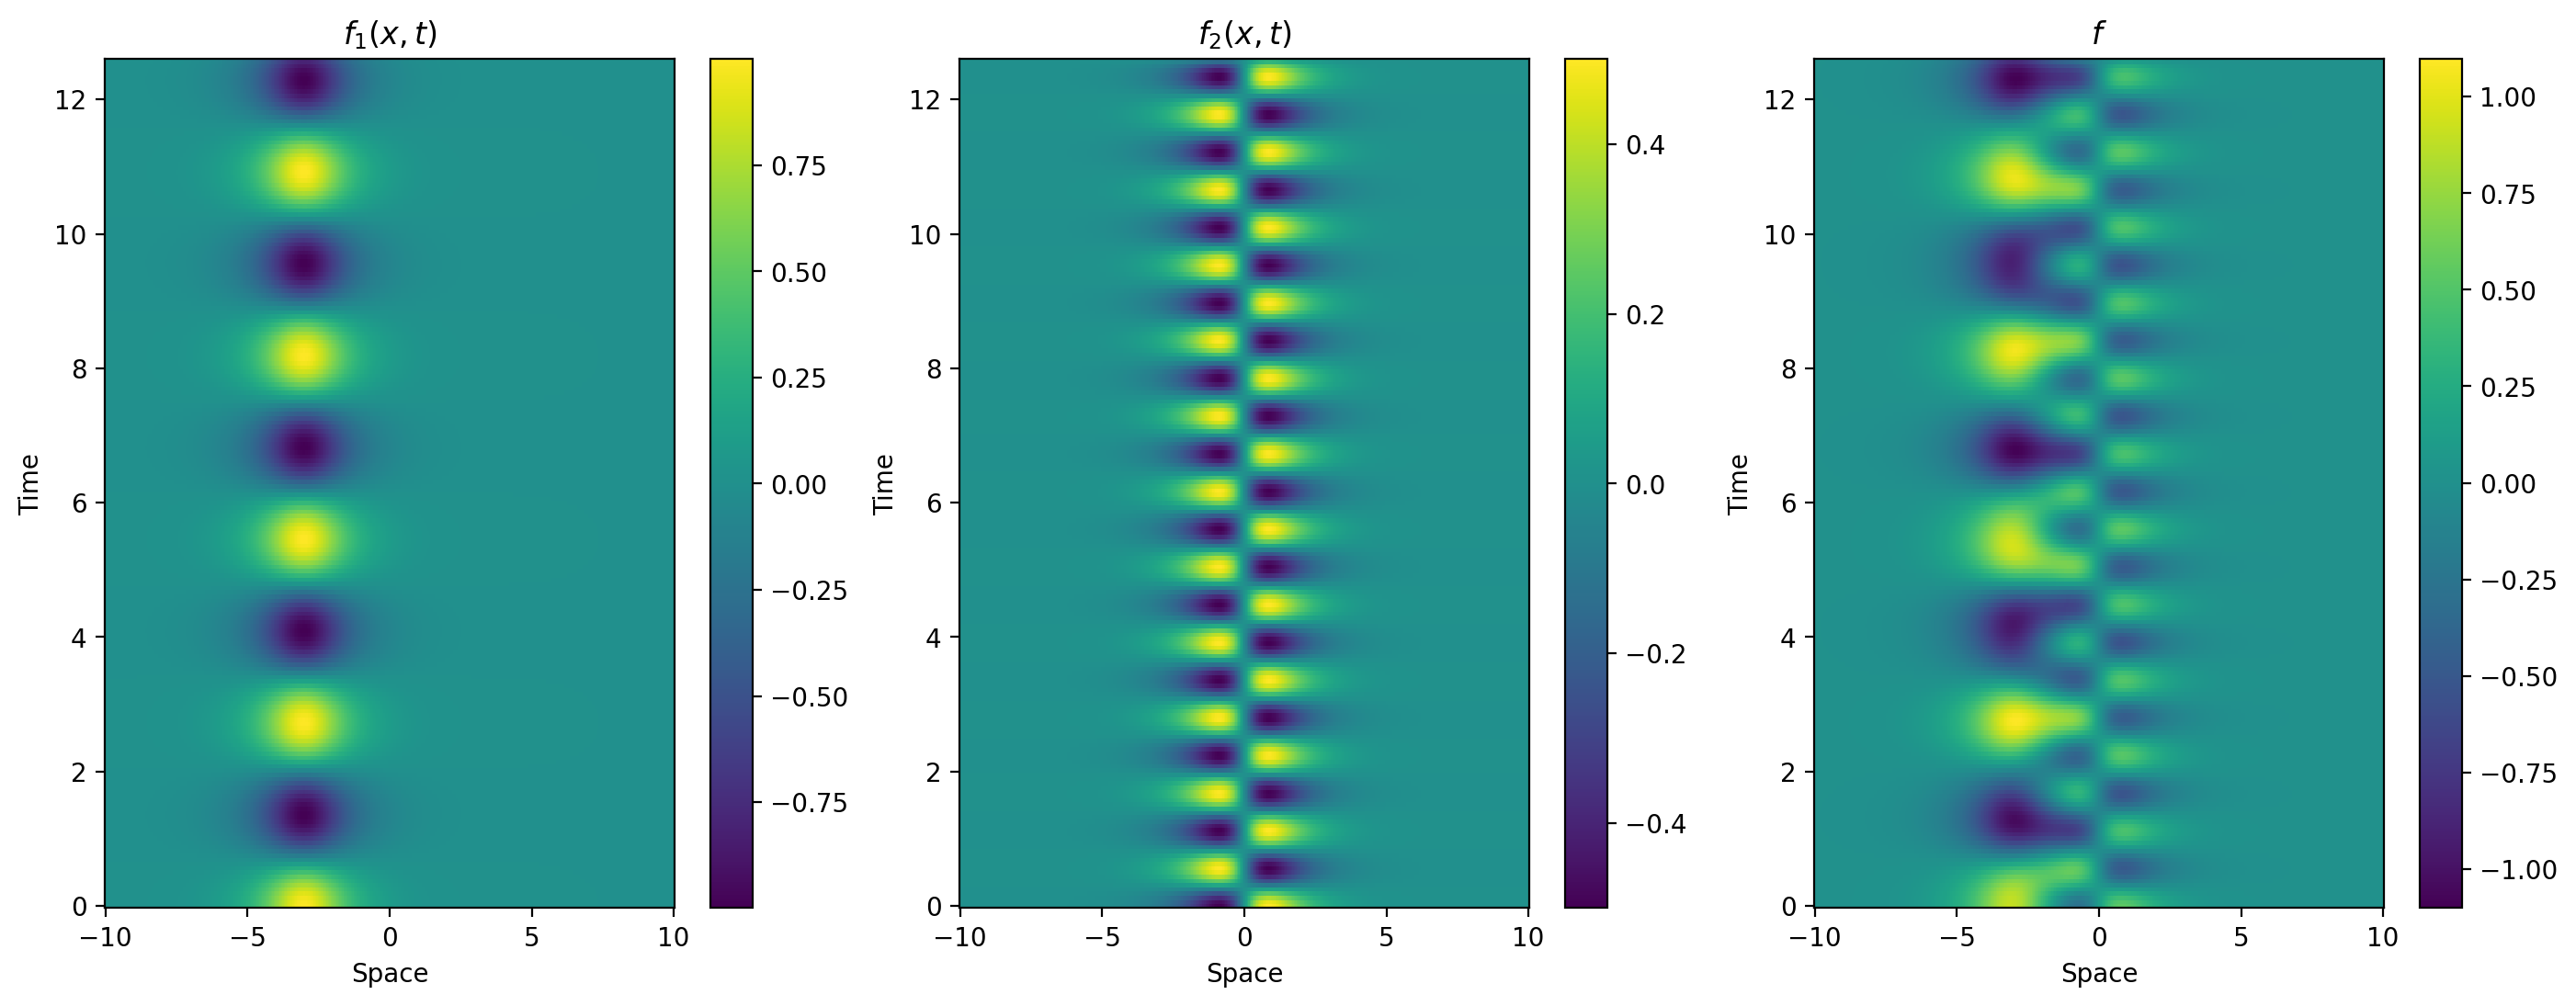

In [197]:
# functions without noise 
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$"]
data = [X1, X2, X]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 136), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()


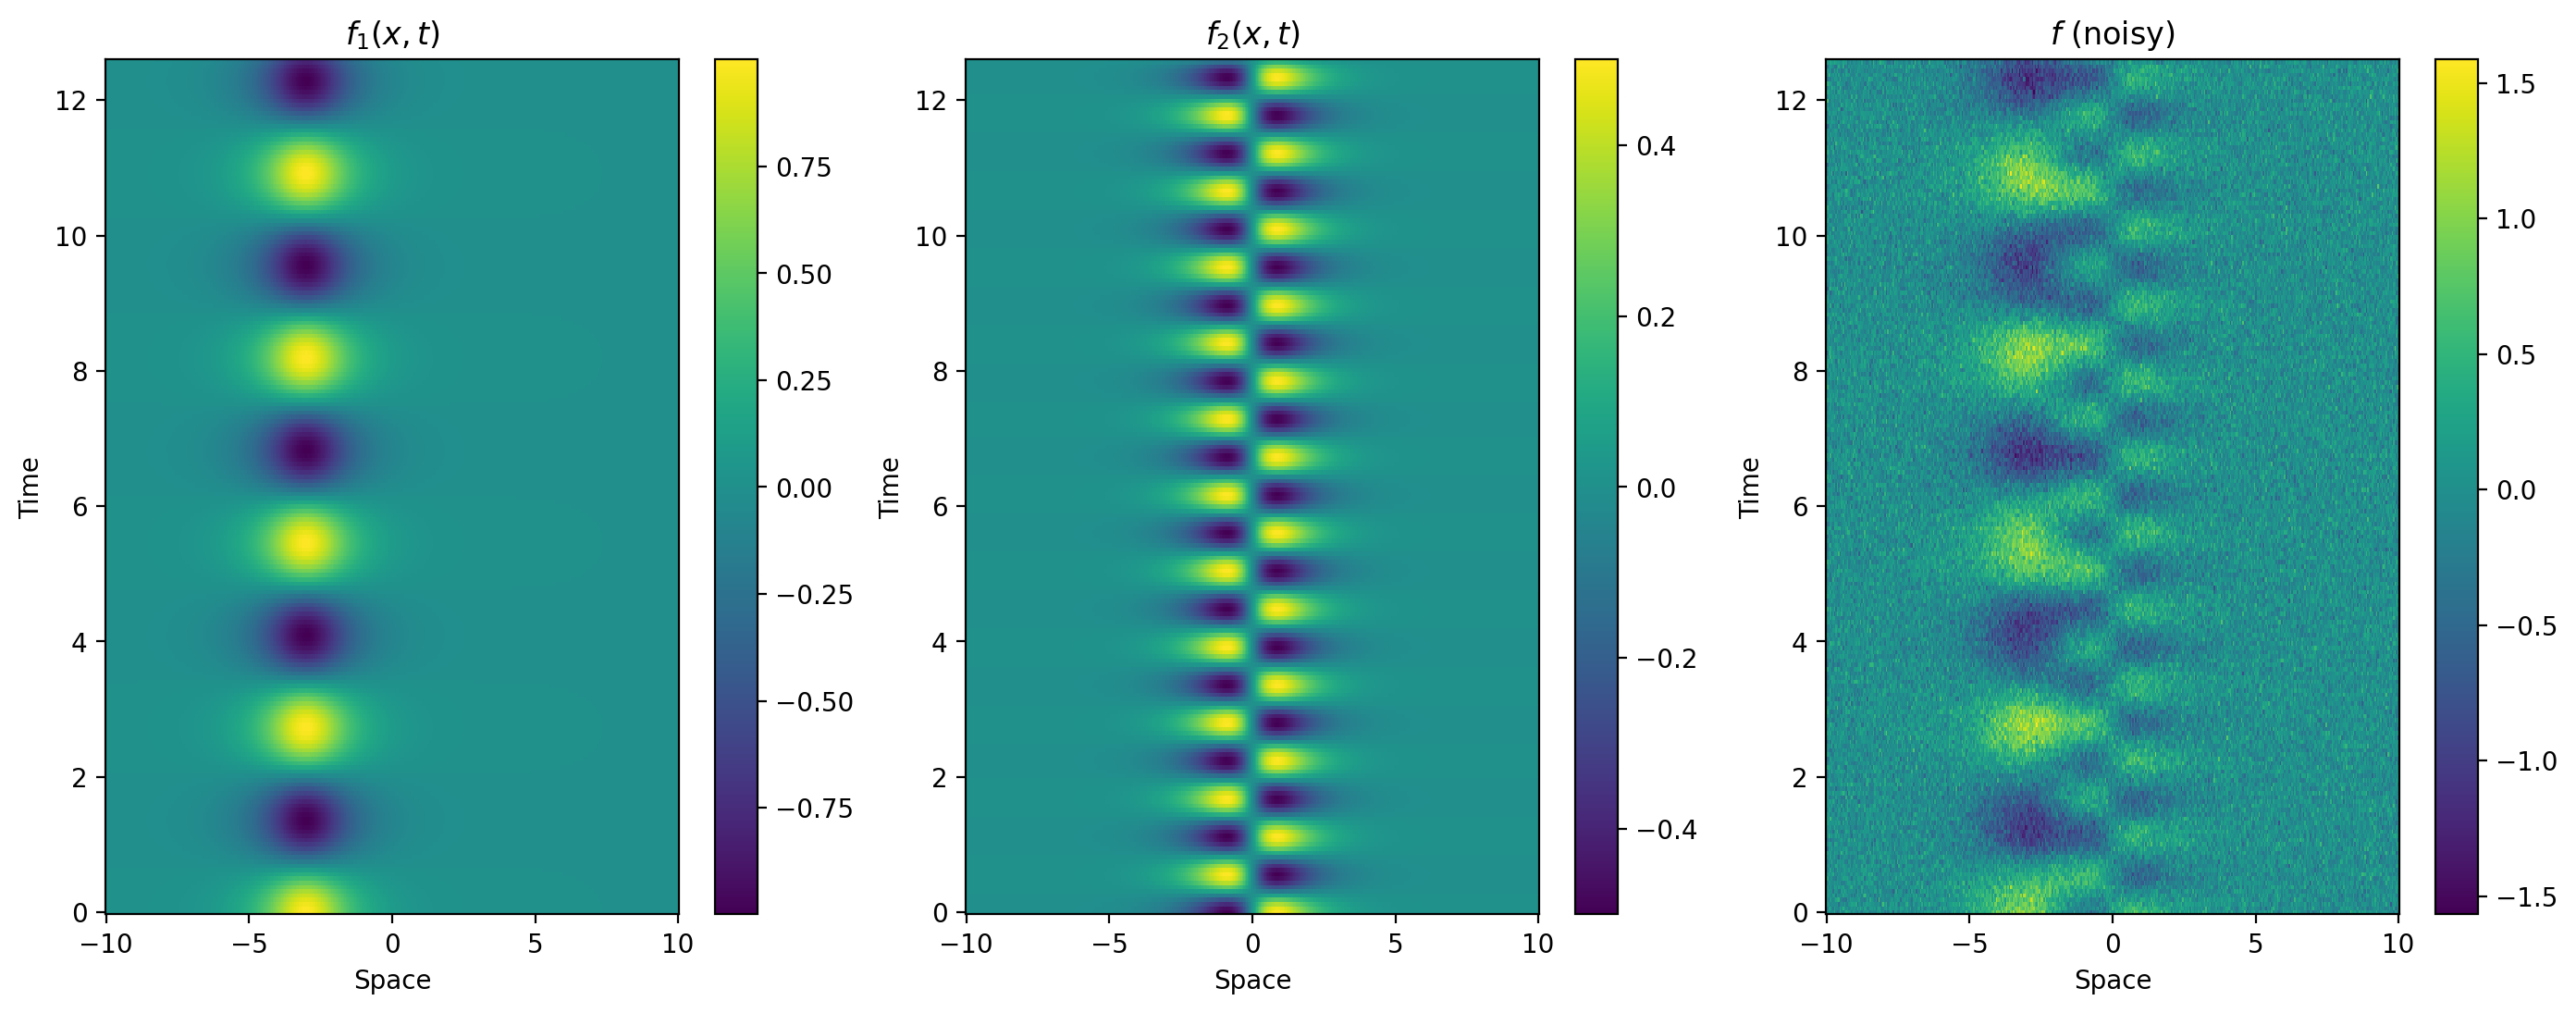

In [198]:
# functions with noise
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$ (noisy)"]
data = [X1, X2, Xn]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

In [212]:
# apply SVD for comparison
U, Sigma, Vh = np.linalg.svd(X.T)


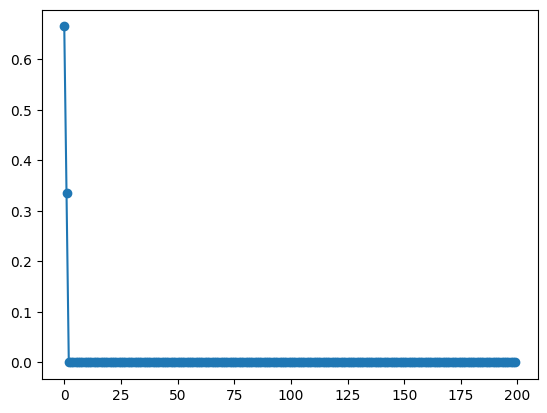

In [200]:
normalized_sv = Sigma / np.sum(Sigma)
plt.plot(normalized_sv, marker='o')
plt.show()

In [221]:
Sigma[0]

65.8335267262227

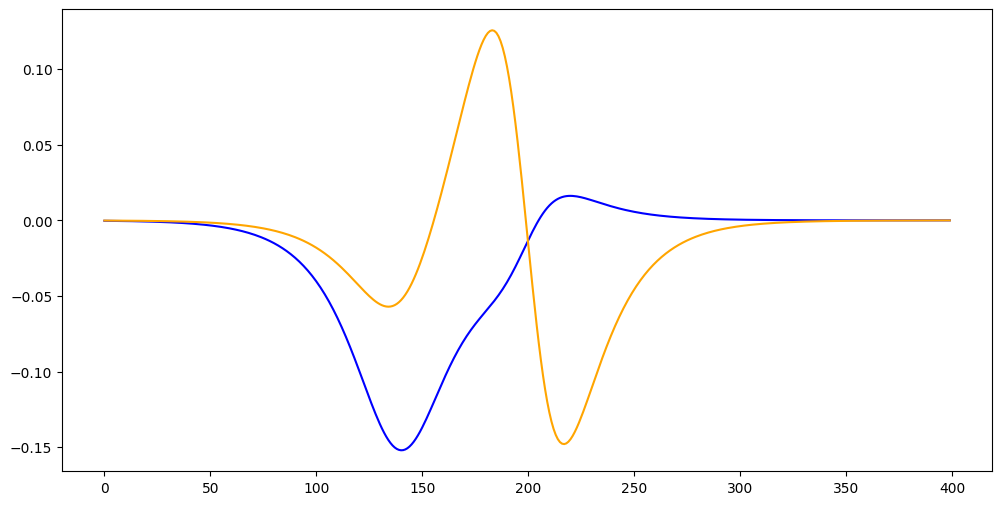

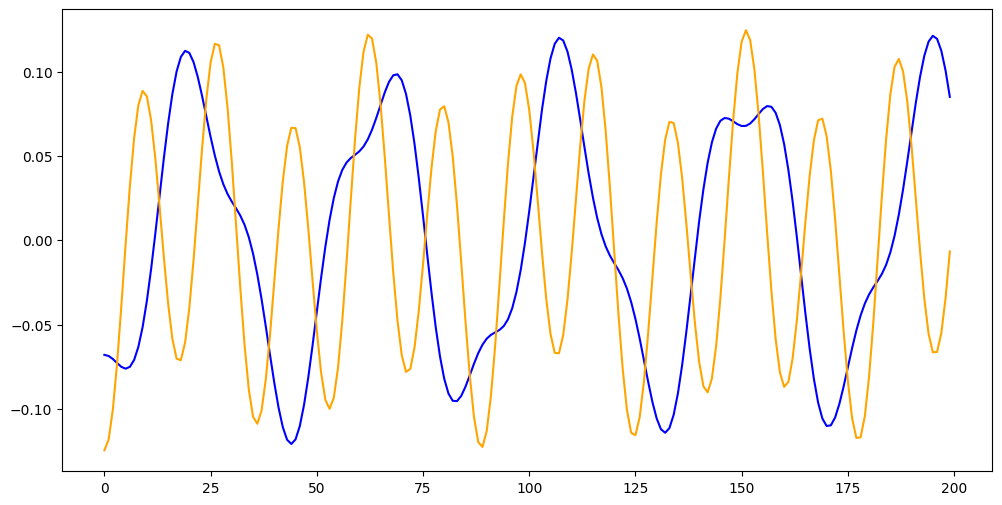

In [201]:
plt.figure(figsize=(12, 6))
plt.plot(U.real[:, 0], color='blue')
plt.plot(U.real[:, 1], color='orange')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(V.T.real[:, 0], color='blue')
plt.plot(V.T.real[:, 1], color='orange')
plt.show()

In [202]:
X_new = X.T
X_new1 = X_new[:, :-1]
X_new2 = X_new[:, 1:]

In [203]:
r = 2
U_new, S_new, Vh_new = np.linalg.svd(X_new1)
U_new, S_new, V_new = U_new[:, :r], S_new[:r], Vh_new[:, :r]


In [204]:
A_tilde = U_new.T @ X_new2 @ V_new @ np.linalg.inv(np.diag(S_new))
D, W = np.linalg.eig(A_tilde)

In [205]:
# DMD modes
Phi = X_new2 @ V_new @ np.linalg.inv(np.diag(S_new)) @ W

In [206]:
lambda_ = np.diag(D)
omega = np.log(lambda_) / dt

/tmp/ipykernel_4107549/967052894.py:2: RuntimeWarning: divide by zero encountered in log
  omega = np.log(lambda_) / dt


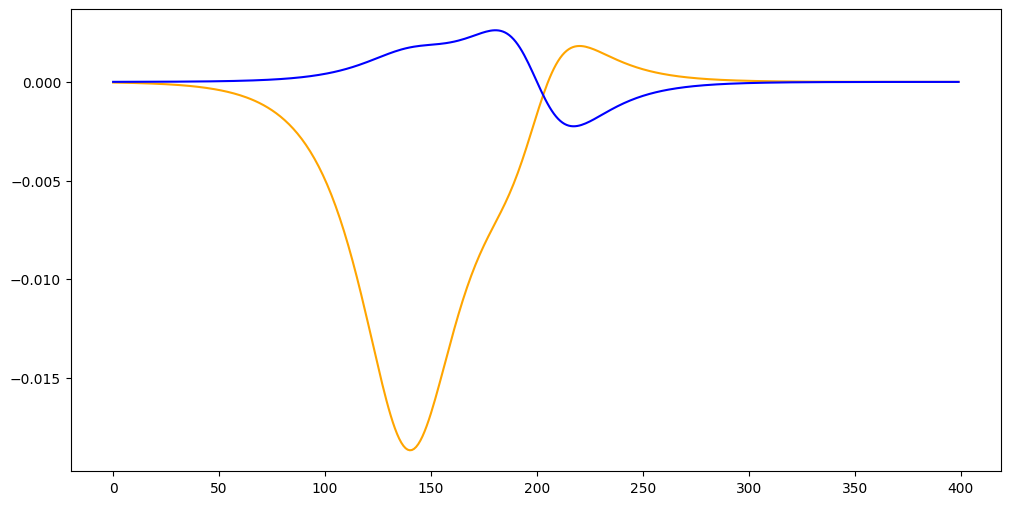

In [207]:
plt.figure(figsize=(12, 6))
plt.plot(Phi[:, 0], color='orange')
plt.plot(Phi[:, 1], color='blue')
plt.show()

/data/u_kamm_software/EEG data analysis/eeg_llm/.venv/lib/python3.9/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1.2262742751522092e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


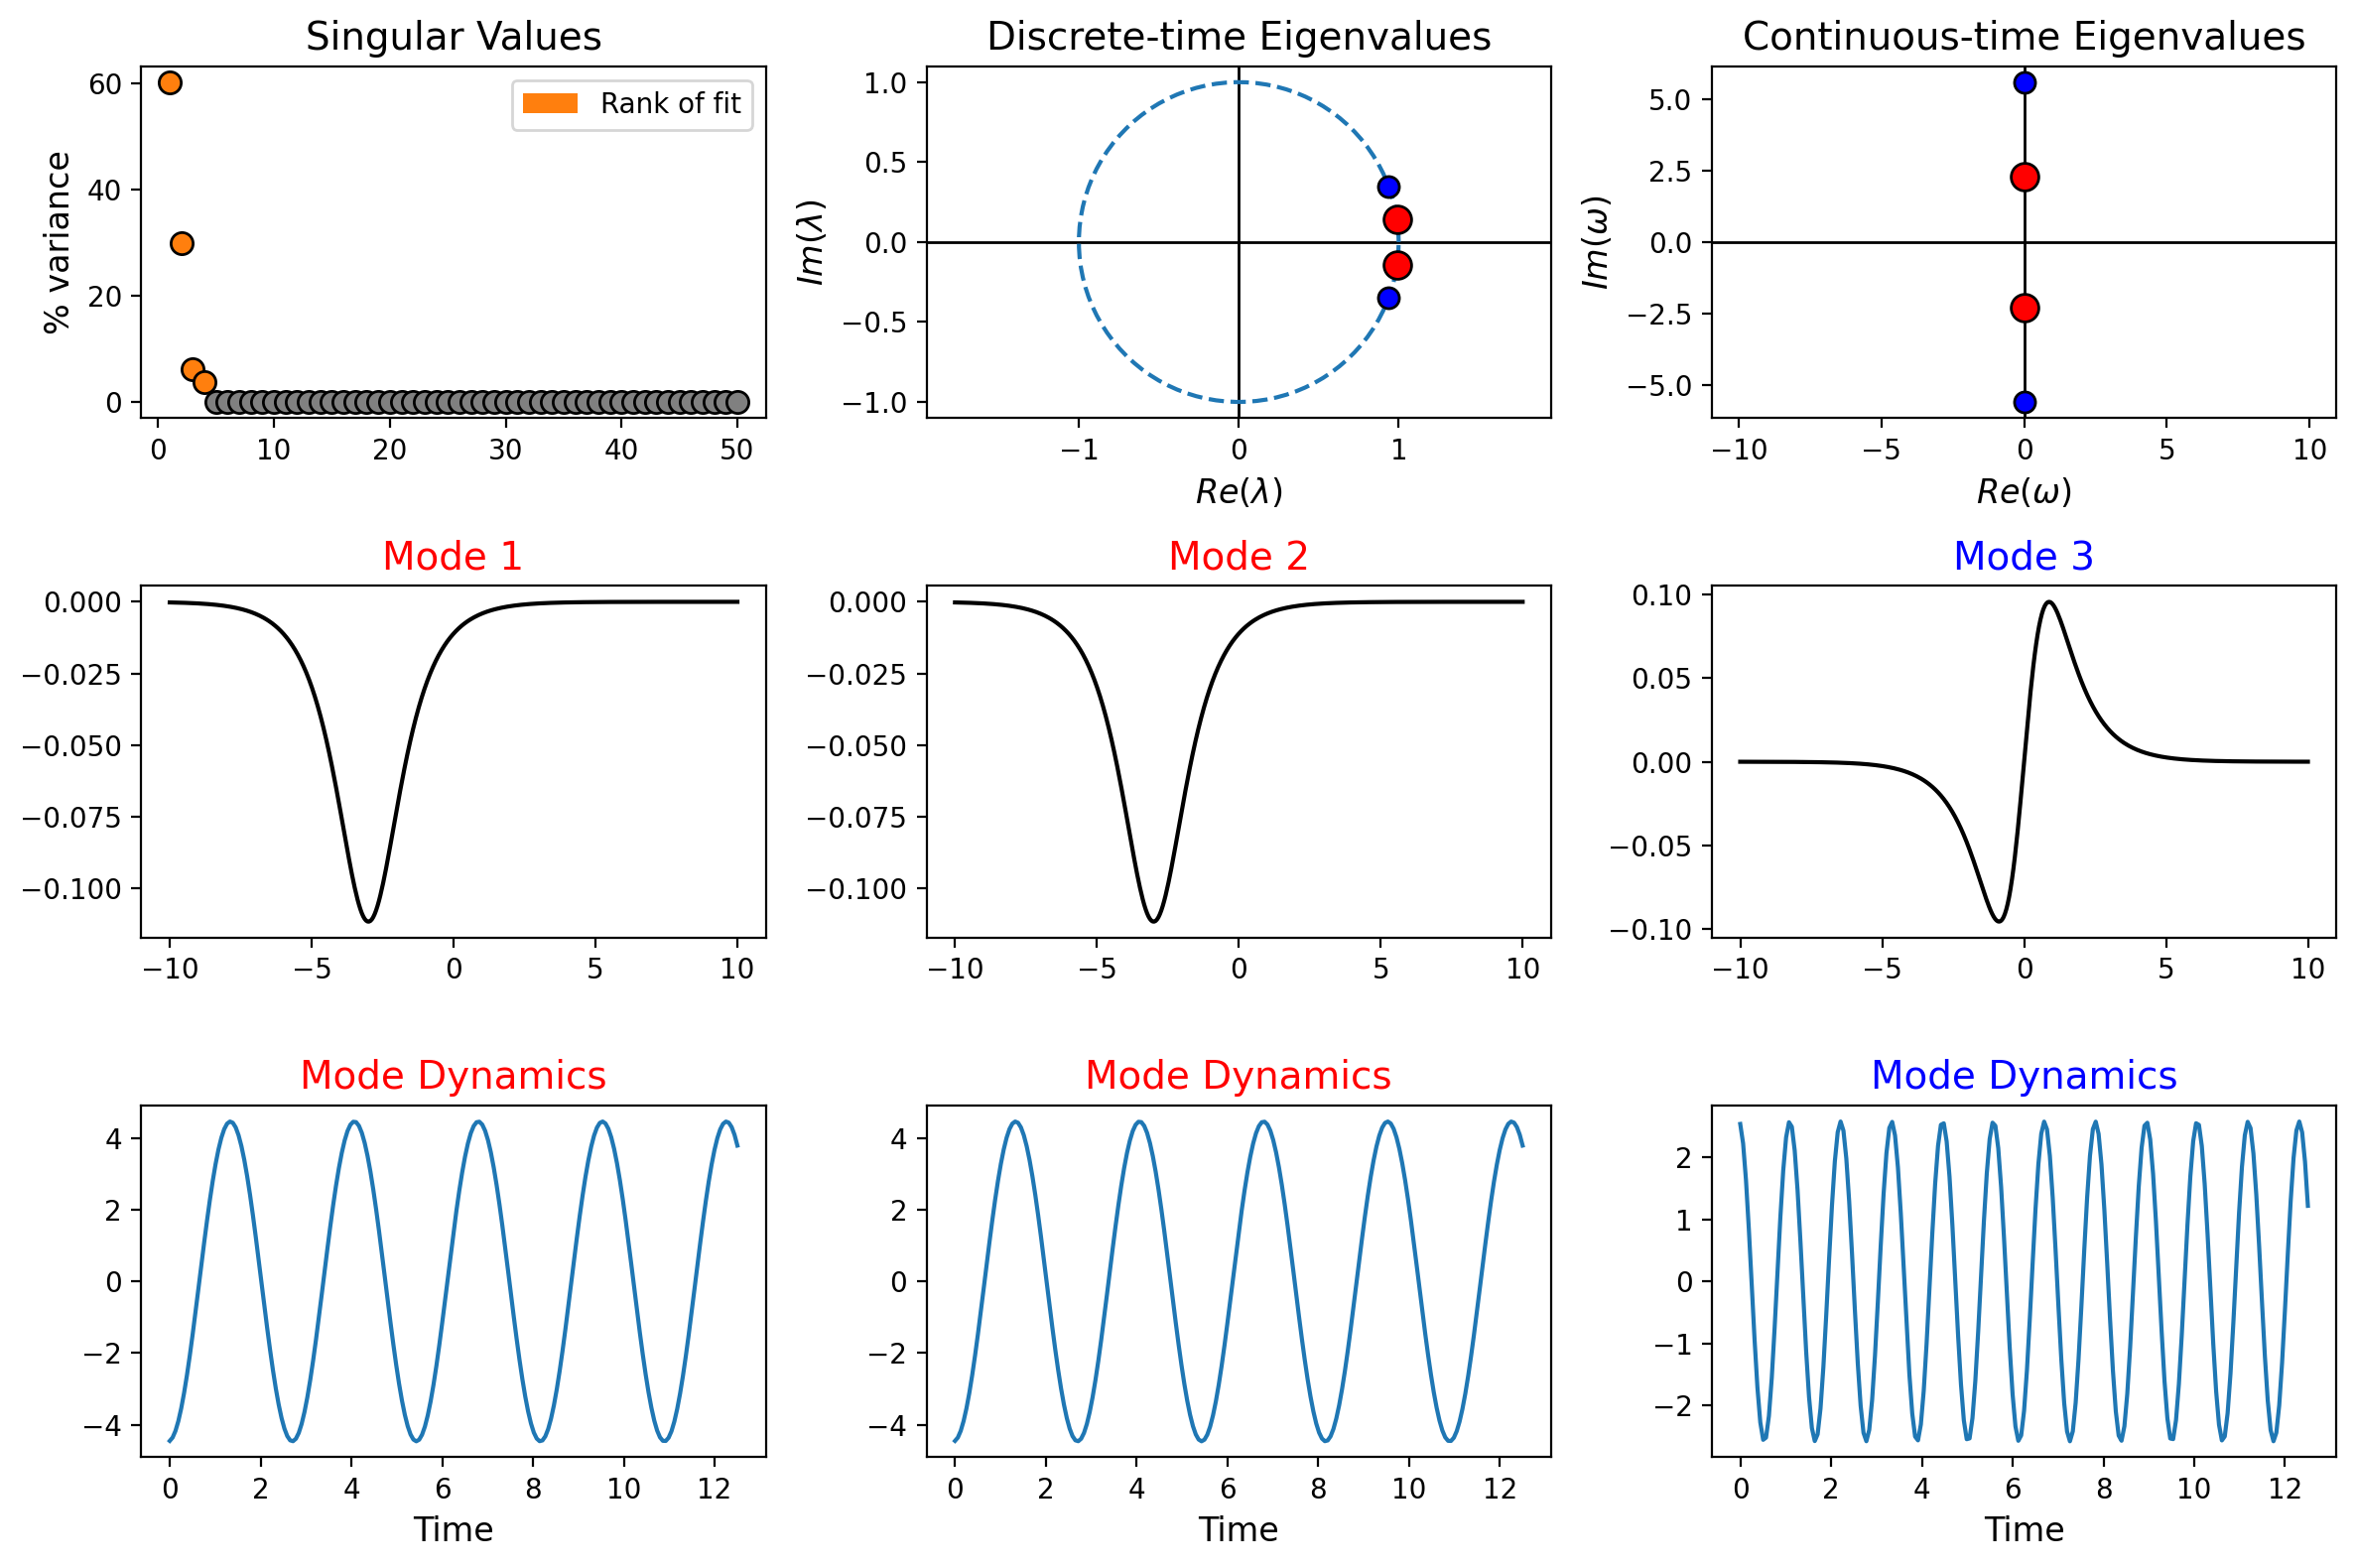

Frequencies (imaginary component): [0.+2.3j 0.-2.3j 0.+5.6j 0.-5.6j]


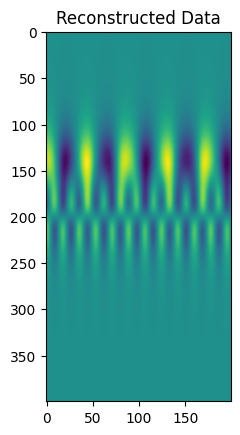

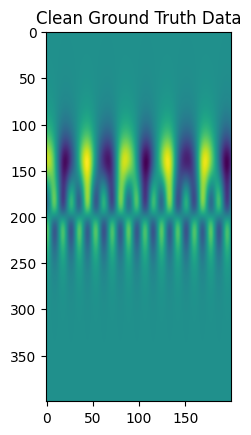

In [208]:
d = 2 
dmd = DMD(svd_rank=4)
delay_dmd = hankel_preprocessing(dmd, d)
delay_dmd.fit(X.T)
plot_summary(delay_dmd, x=x, t=dt, d=d)
print(f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=12)}")
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()